In [1]:
from pathlib import Path
import csv
from PIL import Image
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

Create manually a paths.csv file in /data that contains on each the absolute path to a dataset: \
DatasetName,PathToDataset

The csv is read in

In [3]:
paths_to_data = {}

with open('../data/paths.csv', newline='') as csvfile:
    pathsreader = csv.reader(csvfile, delimiter=';')
    for row in pathsreader:
        paths_to_data[row[0]] = Path(row[1])

In [4]:
path_cityscapes = paths_to_data["Cityscapes"]
path_cityscapes_leftImg8bit = path_cityscapes / 'leftImg8bit_trainvaltest (11GB)' / 'leftImg8bit'
path_cityscapes_rightImg8bit = path_cityscapes / 'rightImg8bit_trainvaltest (11GB)' / 'rightImg8bit'
path_cityscapes_disparity = path_cityscapes / 'disparity_trainvaltest (3.5GB)' / 'disparity'

In [16]:
def calculate_new_size(image, max_height):
    """
    """

    # width = image.size[0]
    # height = image.size[1]
    height, width, channels = image.shape 

    ratio = max_height / height

    new_width = int(ratio * width)
    new_height = int(max_height)

    return (new_width, new_height)

In [8]:
path_target = path_cityscapes.parent / 'Resized'

def compute_depth from https://github.com/itberrios/CV_projects/blob/main/multitask_depth_seg/data_exploration/cityscapes_dataset_depth_intuition.ipynb

In [60]:
def compute_depth(disparity : np.ndarray, 
                  w : int = 2048, 
                  h : int = 1024, 
                  inpaint_radius : int = None, 
                  baseline : float = 0.209313, 
                  f : float = 2262.52, 
                  max_depth : int = 500) -> np.ndarray:
    """ Computes smooth depth map from disparity 
        Inputs:
            disparity - uint16 dispairty image, 
            w - disparity width, 
            h - disparity height, 
            inpaint_radius - inpainting radius, 
            baseline stereo baseline distance (meters), 
            f - camera focal length (pixels) 
                For CityScapes:
                    fx = 2262.52 
                    fy = 2265.3017905988554 
            max_depth - maximum valid depth (meters)
        Outputs: 
            depth - computed depth map
        """
    
    """ NOTE: For training, need to process all input images just like this! """
    # crop noisy areas and resize
    # disparity = cv.resize(disparity[50:int(h*0.8), 100:], (w,h))
    disparity = disparity[50:int(h*0.8), 100:]

    # inpaint invalid disparity
    if inpaint_radius:
        disparity = cv.inpaint(disparity, 
                                np.uint8(255*(disparity <= 1)), 
                                inpaintRadius=inpaint_radius, 
                                flags=cv.INPAINT_TELEA)

    # blur to reduce noise
    disparity = cv.medianBlur(disparity, 5)

    # scale to get True Disparity
    disparity = disparity.astype(np.float32)
    disparity[disparity > 0] = (disparity[disparity > 0] - 1) / 256

    # compute depth
    depth = baseline * f / (disparity + 0.1)

    # clip and return
    return np.clip(depth, 0, max_depth)

In [61]:
def prep_city_data(set_name, city, path_cityscapes_leftImg8bit, path_cityscapes_rightImg8bit, path_cityscapes_disparity, path_target, max_height):

    path_city = path_cityscapes_leftImg8bit / set_name / city
    for path_left_image in [x for x in path_city.iterdir()]:
        image_name = path_left_image.stem[0:-12]
        
        path_right_image = path_cityscapes_rightImg8bit / set_name / city / (image_name + "_rightImg8bit.png")
        path_disparity_image = path_cityscapes_disparity / set_name / city / (image_name + "_disparity.png")

        left_image = cv.imread(path_left_image, cv.COLOR_BGR2RGB)
        # right_image = cv.imread(path_right_image, cv.COLOR_BGR2RGB)
        disparity_image = cv.imread(path_disparity_image, cv.IMREAD_UNCHANGED)

        depth_image = compute_depth(disparity_image, inpaint_radius=12)
        
        w = 2048
        h = 1024
        # left_image_resized = cv.resize(left_image[50:int(h*0.8), 100:], (w,h))
        left_image_crop = left_image[50:int(h*0.8), 100:]

        # resize
        new_size = calculate_new_size(left_image_crop, max_height)
        left_image_resized = cv.resize(left_image_crop, new_size)
        depth_image_resized = cv.resize(depth_image, new_size)
        
        # Save left image
        cv.imwrite(path_target / 'left_images' / set_name / (image_name + "_left_image.png"), left_image_resized)
        cv.imwrite(path_target / 'depth' / set_name / (image_name + "_depth_image.png"), depth_image_resized)

MAX_HEIGHT = 400

# prep_city_data('train', 'aachen', path_cityscapes_leftImg8bit, path_cityscapes_rightImg8bit, path_cityscapes_disparity, path_target, MAX_HEIGHT)


In [ ]:
# Resize images and create depth map
for set_name in [x.stem for x in path_cityscapes_leftImg8bit.iterdir() if x.is_dir()]:
    print(set_name)
    path_set = path_cityscapes_leftImg8bit / set_name
    for city in [x.stem for x in path_set.iterdir() if x.is_dir()]:            
            prep_city_data(set_name,
                        city,
                        path_cityscapes_leftImg8bit,
                        path_cityscapes_rightImg8bit,
                        path_cityscapes_disparity,
                        path_target,
                        MAX_HEIGHT)

test
train
val


## View Data

In [11]:
# path_sample_image = Path('data') / 'left_images' / 'train' / 'data/left_images/train/aachen_000000_000019_left_image.png'
path_sample_image = Path('../data/left_images/train/aachen_000000_000019_left_image.png')
path_sample_depth = Path('../data/depth/train/aachen_000000_000019_depth_image.png')

Text(0.5, 1.0, 'Depth Aachen')

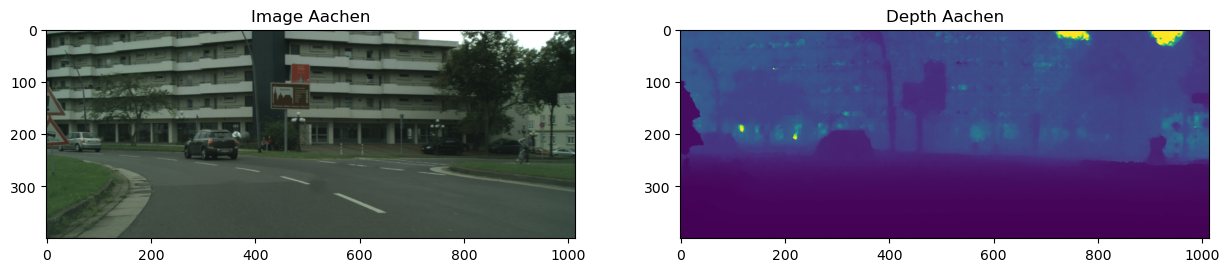

In [17]:
sample_image  = Image.open(path_sample_image)
sample_depth  = Image.open(path_sample_depth)


fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].imshow(sample_image)
ax[0].set_title('Image Aachen')
ax[1].imshow(sample_depth)
ax[1].set_title('Depth Aachen')
